GPU availability: True; automation will be using: cuda:0 Mounted at /content/gdrive/
9371
3131
6213
17002
3710
17143
6180
10812
2694
18349
4503
13122
1541
20686
22222
17147
391
15403
16602
7176
18761
16710
16169
3885
6867
597
12677
658
11104
5508
1549
10835
(32, 3, 256, 256)
(32, 18, 32, 32)
(32, 1, 256, 256)


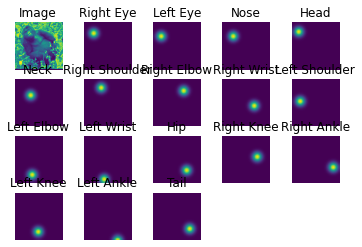

In [3]:
from matplotlib.transforms import ScaledTranslation
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np
import torch.nn.functional as F 
import os
import json
from tqdm import tqdm
from google.colab import drive
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import math
import cv2
import skimage.filters as filters
import skimage.transform as transform
import sys
from sklearn import preprocessing

np.set_printoptions(threshold=sys.maxsize)

#Set device to GPU if possible
cuda = torch.cuda.is_available()
device = 'cuda:0' if cuda else 'cpu'

#print(cuda)
print("GPU availability: {}; automation will be using: {} ".format(cuda, device), end= '')

#Path to where data is stored
drive.mount('/content/gdrive/', force_remount = True)
dir_path = "/content/gdrive/MyDrive/Colab Notebooks/Data/"

#Set automation to Train or Test
Train = False

def Load_Data():

  if(Train == True):
    dir = os.path.join(dir_path, "train_annotation.json")
  else:
    dir = os.path.join(dir_path, "val_annotation.json")

  with open(dir) as f:
      dictionary = json.load(f)
      feature_list = [item for item in dictionary['data']]
      feature_list = np.asarray(feature_list)

  return(feature_list)

def get_image(feature_list, index):

  if(Train == True):
    dir_image_folder = os.path.join(dir_path, "train")
  else:
    dir_image_folder = os.path.join(dir_path, "val")
    

  feature = feature_list[index]

  dir_image = os.path.join(dir_image_folder, feature["file"])

  img = mpimg.imread(dir_image)

  #plt.imshow(img)

  return img

#Return batches with image filepaths. Will need to "get_image" by batch as
#RAM capacity is surpassed if we attempt to get all images within the create batch
#method.

def create_batches(data, batch_size):

  data_count = len(data)
  index_array = random.sample(range(0, data_count), data_count)

  mini_batch_count = math.floor(data_count/batch_size)

  mini_batch_x = []

  for batch in range(int(mini_batch_count)):
    batch_x = []
    try:
      for value in range(batch_size):
        batch_x.append(index_array[value + batch * batch_size])
      batch_x = np.asarray(batch_x)
      mini_batch_x.append(batch_x)
    except:
      batch_x = np.asarray(batch_x)
      mini_batch_x.append(batch_x)
  mini_batch_x = np.asarray(mini_batch_x)
  return mini_batch_x
#torch_data.dataloader(data_class, batch_size = 1, shuffle = True)

def get_batch_data(data, batch, size):
  batch_data_train_images = []
  batch_data_heat_maps = []
  batch_data_center_heat_map = []

  heat_map_size = (32, 32)
  center_map_size = (256, 256)

  for value in range(len(batch)):
    print(batch[value])
    img = get_image(data, batch[value])
    cropped_image, cropped_joints, cropped_center = crop_image(img, data[batch[value]], size)
    #Create ground truth heatmap and center heat map
    heat_maps, center_heat_map = get_heatmap([np.zeros(heat_map_size), np.zeros(center_map_size)], cropped_joints/8, cropped_center)
    train_image = np.transpose(cropped_image, (2, 0, 1))/255.0
    batch_data_train_images.append(train_image)
    batch_data_heat_maps.append(heat_maps)
    batch_data_center_heat_map.append(center_heat_map)

  batch_data_train_images = np.asarray(batch_data_train_images)
  batch_data_heat_maps = np.asarray(batch_data_heat_maps)
  batch_data_center_heat_map = np.asarray(batch_data_center_heat_map)

  return batch_data_train_images, batch_data_heat_maps, batch_data_center_heat_map

def crop_image(img, features, image_size):
  joint_points = features["landmarks"]
  bbox = features["bbox"]
  visibility = np.asarray(features["visibility"])

  x = []
  y = []

  for value in range(0, len(joint_points), 2):
    x.append(joint_points[value])
  width_points = np.transpose(np.asarray(x))

  for value in range(1, len(joint_points), 2):
    y.append(joint_points[value])
  height_points = np.transpose(np.asarray(y))

  Height, Width = img.shape[0], img.shape[1]

  bbox_x1 = math.floor(bbox[0])
  bbox_x2 = math.floor(bbox[0] + bbox[2])
  bbox_y1 = math.floor(bbox[1])
  bbox_y2 = math.floor(bbox[1] + bbox[3])

  cropped_x = bbox_x2 - bbox_x1
  cropped_y = bbox_y2 - bbox_y1

  if(cropped_y > cropped_x):
    cropped_difference = cropped_y - cropped_x
    bbox_x1 = bbox_x1 + math.floor(cropped_difference/2)
    bbox_x2 = bbox_x2 + math.floor(cropped_difference/2)
  elif(cropped_x > cropped_y):
    cropped_difference = cropped_x - cropped_y
    bbox_y1 = bbox_y1 + math.floor(cropped_difference/2)
    bbox_y2 = bbox_y2 + math.floor(cropped_difference/2)

  #Sift our Width and Height points for any zero values
  width_points = np.where(width_points != 0, width_points - bbox_x1, width_points)
  height_points = np.where(height_points != 0, height_points - bbox_y1, height_points)

  #Determine if padding is needed for image
  padding = 0

  if((bbox_y1 < 0) or (bbox_x1 < 0) or (bbox_y2 > Height) or (bbox_x2 > Width)):
    padding = math.floor(max(-bbox_y1, -bbox_x1, bbox_y2 - Height, bbox_x2 - Width))
    img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)))

  img = img[bbox_y1 + padding : bbox_y2 + padding, bbox_x1 + padding : bbox_x2 + padding]

  bbox[0] = bbox[0] - bbox_x1
  bbox[1] = bbox[1] - bbox_y1

  #Resize our image
  Height, Width = img.shape[0], img.shape[1]
  width_points = (width_points * image_size)/Width
  height_points = (height_points * image_size)/Width

  center = np.array((1, 2))

  center[0] = (abs(math.floor((bbox_x2 - bbox_x1)/2))) * (image_size/Width)
  center[1] = (abs(math.floor((bbox_y2 - bbox_y1)/2))) * (image_size/Height)

  img = cv2.resize(img, (image_size, image_size))

  joint_points = [[width_points[i], height_points[i]] for i in range(len(height_points))]

  return img, np.asarray(joint_points), np.asarray(center)

def get_heatmap(img, joint_points, cropped_center):
  heat_map_size = img[0]
  #print(heat_map_size.shape)
  Height, Width = heat_map_size.shape[0], heat_map_size.shape[1]
  #print(joint_points.shape)

  #Build shell for heatmap of each joint_point
  heat_maps = np.zeros((Height, Width, (len(joint_points) + 1)))

  for joint in range(len(joint_points)):
    if((joint_points[joint, 0] == 0) and (joint_points[joint, 1] == 0)):
      continue

    if(joint_points[joint, 1] >= Height):
      joint_points[joint, 1] = Height - 1
    if(joint_points[joint, 0] >= Width):
      joint_points[joint, 0] = Width - 1
    
    #Build heatmap of joint
    heat_map = heat_maps[:, :, joint]
    x = math.floor(joint_points[joint, 1])
    y = math.floor(joint_points[joint, 0])

    #Set heatmap of joint within heatmap image
    heat_map[x][y] = 1
    heat_map = filters.gaussian(heat_map, sigma = 2)

    #scale image to [0, 1]
    scale = np.max(heat_map)
    heat_map = heat_map/scale
    heat_maps[:, :, joint] = heat_map

  #add background dimensions
  heat_maps[:, :, len(joint_points)] = 1 - np.max(heat_maps[:, :, :len(joint_points)], axis = 2)
  heat_maps = np.transpose(heat_maps, (2, 0, 1))


  #Center image
  center_heat_map = img[1] #256x256

  Height, Width = center_heat_map.shape[0], center_heat_map.shape[1]
  x = math.floor(cropped_center[1]); y = math.floor(cropped_center[0])
  center_heat_map[x][y] = 1

  center_heat_map = filters.gaussian(center_heat_map, sigma = 2)
  scale = np.max(center_heat_map)
  center_heat_map = center_heat_map/scale
  center_heat_map = np.expand_dims(center_heat_map, axis = 0)
  #print(center_heat_map.shape)
  return heat_maps, center_heat_map

def view_heat_maps(img, heat_maps):
  Height, Width = img.shape[0], img.shape[1]

  heat_maps = np.transpose(heat_maps)

  dictionary_of_names = {0: 'Image', 1: 'Right Eye', 2: 'Left Eye', 3: 'Nose', 4: 'Head',
    5: 'Neck', 6: 'Right Shoulder', 7: 'Right Elbow', 8: 'Right Wrist', 9: 'Left Shoulder',
    10: 'Left Elbow', 11: 'Left Wrist', 12: 'Hip', 13: 'Right Knee', 14: 'Right Ankle',
    15: 'Left Knee', 16: 'Left Ankle', 17: 'Tail'}

  #print(heat_maps.shape)
  if(heat_maps.shape[0] != Height):
    heat_maps = transform.resize(heat_maps, (Height, Width))
  elif(heat_maps.shape[1] != Width):
    heat_maps = transform.resize(heat_maps, (Height, Width))

  for value in range((heat_maps.shape[2])): #256x256x18
    #print(value)
    plt.subplot(4, 5, value + 1)
    plt.title(dictionary_of_names[value], fontdict = {"fontsize" : 12})
    plt.axis("off")

    if value == 0:
      plt.imshow(img)
    else:
      plt.imshow(heat_maps[:, :, value - 1])
  plt.show()


if __name__ == '__main__':
  #Config
  crop_size = 256
  batch_size = 32

  #Load in the data for training and/or validation
  data = Load_Data()

  #Create batches containing unique indexes expanding the length of our training set
  batches_x = create_batches(data, batch_size)

  #Grab the images from each batch containing unique indexes of training data
  train_images_batch, heat_images_batch, center_image_batch = get_batch_data(data, batches_x[0], crop_size)

  print(train_images_batch.shape) # (batch size, channels, height, width)
  print(heat_images_batch.shape)
  print(center_image_batch.shape)
  #print(center_image_batch[0][0])


  view_heat_maps(train_images_batch[0][0], heat_images_batch[0])


# U-Net standard implementation (Tom)

In [4]:

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras import Input #as INP

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

#https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, trainstate,
                 train_partition_size,
                 val_partition_size,
                 batch_size,
                 input_size=(256, 256, 3),
                 shuffle=True):
        #self.reset()
        
        #self.df = df.copy()
        #self.X_col = X_col
        #self.y_col = y_col
        self.trainstate = trainstate
        self.train_partition_size = train_partition_size
        self.val_partition_size = val_partition_size
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        if (self.trainstate == True):
            Train = True
            self.data_train = Load_Data()[0:self.train_partition_size]
            self.batches_x = create_batches(self.data_train, batch_size)
            self.n = len(self.data_train)
        if (self.trainstate == False):
            Train = False
            self.data_train = Load_Data()[0:self.val_partition_size]
            self.batches_x = create_batches(self.data_train, batch_size)
            self.n = len(self.data_train)
        #self.n_name = df[y_col['name']].nunique()
        #self.n_type = df[y_col['type']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            print("Not shuffling")
            #self.data_train = self.data_train.sample(frac=1).reset_index(drop=True)
    
    
    def __getitem__(self, index):
        
        #batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        # Load training data batch
        #print("Loading batch ",index)
        x_train, y_train, x_train_center = get_batch_data_tb(self.data_train, self.batches_x[index], crop_size)
        x_train = np.rollaxis(x_train,1,4)
        y_train = np.rollaxis(y_train,1,4)[:,:,:,0:17]

        return x_train, y_train
    
    def __len__(self):
        return self.n // self.batch_size

    # def __reset__(self):
    #     #set to intial values


In [5]:
def custom_loss(y_true, y_pred):

  EPSILON = 1e-6

  def _op_sum(x):
      return keras.sum(x)

  inter = _op_sum(y_true * y_pred)
  union = (
      _op_sum(y_true ** 2)
      + _op_sum(y_pred ** 2)
      - _op_sum(y_true * y_pred)
  )
  iou = (inter + EPSILON) / (union + EPSILON)
  iou = keras.mean(iou)
  return 1 - iou




def unet(input_size):
    inputs = Input(shape=input_size, name='primates')
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)


    # up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    # merge7 = concatenate([conv3,up7], axis = 3)
    # conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    # conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    # up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    # merge8 = concatenate([conv2,up8], axis = 3)
    # conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    # conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    # up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    # merge9 = concatenate([conv1,up9], axis = 3)
    # conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

    # #MOD
    # drop_m1 = Dropout(0.5)(conv9)
    # pool_m1 = MaxPooling2D(pool_size=(2, 2))(drop_m1)
    # ##

    # conv9_m1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool_m1)

    # #MOD
    # drop_m2 = Dropout(0.5)(conv9_m1)
    # pool_m2 = MaxPooling2D(pool_size=(2, 2))(drop_m2)
    # ##

    # conv9_m2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool_m2)
    
    # #MOD
    # drop_m3 = Dropout(0.5)(conv9_m2)
    # pool_m3 = MaxPooling2D(pool_size=(2, 2))(drop_m3)
    # ##
    
    conv10 = Conv2D(17, 1, activation = 'sigmoid')(conv6)

    model = Model(inputs = inputs, outputs = conv10)


    #loss_function = tf.keras.losses.MeanSquaredError(reduction='auto',name='mean_squared_error')

    model.compile(optimizer = 'Adam', 
                  loss = custom_loss)
                  #loss='mse')
                  #loss='kullback_leibler_divergence')
                  #loss = 'sparse_categorical_crossentropy')
                  #, metrics = ['accuracy'])
    
    model.summary()

    return model

def get_batch_data_tb(data, batch, size):
    batch_data_train_images = []
    batch_data_heat_maps = []
    batch_data_center_heat_map = []

    heat_map_size = (32, 32)
    center_map_size = (256, 256)

    for value in range(len(batch)):
        #print(batch[value])
        # if (value%10 ==0):
        #     print("Processing image #: ",value)
        img = get_image(data, batch[value])
        cropped_image, cropped_joints, cropped_center = crop_image(img, data[batch[value]], size)
        #Create ground truth heatmap and center heat map
        heat_maps, center_heat_map = get_heatmap([np.zeros(heat_map_size), np.zeros(center_map_size)], cropped_joints/8, cropped_center)
        train_image = np.transpose(cropped_image, (2, 0, 1))/255.0
        batch_data_train_images.append(train_image)
        batch_data_heat_maps.append(heat_maps)
        batch_data_center_heat_map.append(center_heat_map)

    batch_data_train_images = np.asarray(batch_data_train_images)
    batch_data_heat_maps = np.asarray(batch_data_heat_maps)
    batch_data_center_heat_map = np.asarray(batch_data_center_heat_map)

    return batch_data_train_images, batch_data_heat_maps, batch_data_center_heat_map

In [4]:
model_2 = unet(input_size = (256,256,3))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 primates (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['primates[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:

#training_generator.reset()
training_generator = CustomDataGen(True, 
                                   train_partition_size = 66917,
                                   val_partition_size = 22306,
                                   batch_size = 32)
# validation_generator = CustomDataGen(False,
#                                      train_partition_size = 66917,
#                                      val_partition_size = 22306,
#                                      batch_size = 32)

# define the checkpoint
#filepath = "model_v01.h5"
dir = os.path.join(dir_path, "model_v03.h5")
cp1= ModelCheckpoint(filepath=dir, monitor='loss', save_best_only=True, verbose=1, mode='min')
callbacks_list = [cp1]


# torch.save(model.state_dict(), dir)

# model = CPM(17).to(device)
# dir = os.path.join(dir_path, "cpm_baseline.pth")
# model.load_state_dict(torch.load(dir))
# model.eval()


train_history = model_2.fit_generator(
    generator = training_generator,
    callbacks = callbacks_list,
    #validation_data = validation_generator,
    #x_train,
    #y_train,
    #batch_size=batch_size,
    epochs=1000
    #validation_data=(x_val, y_val),
)

In [6]:
dir = os.path.join(dir_path, "model_v03.h5")
recon = load_model(dir, custom_objects={'custom_loss':custom_loss})

In [6]:
#x_val[0-5,:,:,:].shape
Train = False
data_val = Load_Data()
batch_test = np.array([10,20,30,40,50,60,70,80,90,100])
x_val, y_val, x_val_center = get_batch_data_tb(data_val, batch_test, crop_size)
x_val = np.rollaxis(x_val,1,4)
y_val = np.rollaxis(y_val,1,4)[:,:,:,0:17]#:17]
#y_val = np.asarray([cv2.resize(y, (256,256)) for y in y_val])
preds = recon.predict(x_val)

1/1 [==============================] - 4s 4s/step


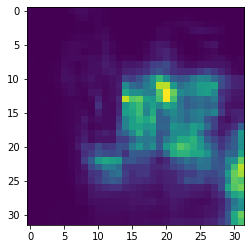

In [7]:
plt.imshow(preds[0,:,:,12])

(10, 17, 32, 32)


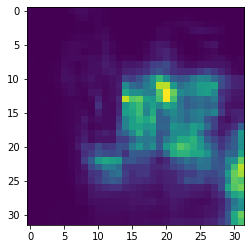

In [8]:
preds2 = np.moveaxis(preds,3,1)
print(preds2.shape)
plt.imshow(preds2[0,12,:,:])

# print(preds2.shape)
# preds3 = np.rollaxis(preds2,1,4)#[:,:,:,0:17]
# print(preds3.shape)
# plt.imshow(preds3[0,3,::])


In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

def predict_test(model):
  #model.eval()
  # test_data = CustomDataGen(False,
  #                                    train_partition_size = 66917,
  #                                    val_partition_size = 22306,
  #                                    batch_size = 32)
  
  test_data = DataLoader(ValData(), batch_size=batch_size, shuffle=False, num_workers=4)
  dir = os.path.join(dir_path, 'val_predictions.json')

  with open(dir) as f:
    dictionary = json.load(f)

  for i, (im, center, bb) in enumerate(test_data):
    print('batch ' + str(i + 1) + '/' + str(len(test_data)))
    #print(im.shape)
    im = im.cpu().detach().numpy()

    #im = im.float().to(device)
    #print(im.shape)
    im = np.moveaxis(im,1,3)
    
    #print(im.shape)
    #y_val = np.rollaxis(y_val,1,4)[:,:,:,0:17]
    #plt.imshow(im[i,:,:,:])
    #print(bb)


    #im = im.float().to(device)
    #center = center.float().to(device)
    
    pred = recon.predict(im)


    #print(pred.shape)
    pred = np.moveaxis(pred,3,1)
    #print(pred.shape)



    for j in range(len(pred)):
      # print(len(pred))
      #plt.imshow(pred[j,0,:,:])
      #print([i*batch_size+j])
      dictionary['data'][i*batch_size+j]['landmarks'] = get_landmarks(pred[j,:,:,:], [bb[0][j],bb[1][j],bb[2][j],bb[3][j]])
      #break

    with open(dir, 'w') as out:
      json.dump(dictionary, out)

    # if (i ==5):
    #   break

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

def crop_image_test(img, features, image_size): #crop_image function for testing-relevant features

  bbox = features["bbox"]
  bb = bbox.copy()

  Height, Width = img.shape[0], img.shape[1]

  bbox_x1 = math.floor(bbox[0])
  bbox_x2 = math.floor(bbox[0] + bbox[2])
  bbox_y1 = math.floor(bbox[1])
  bbox_y2 = math.floor(bbox[1] + bbox[3])

  cropped_x = bbox_x2 - bbox_x1
  cropped_y = bbox_y2 - bbox_y1

  if(cropped_y > cropped_x):
    cropped_difference = cropped_y - cropped_x
    bbox_x1 = bbox_x1 - math.floor(cropped_difference/2)
    bbox_x2 = bbox_x2 + math.floor(cropped_difference/2)
  elif(cropped_x > cropped_y):
    cropped_difference = cropped_x - cropped_y
    bbox_y1 = bbox_y1 - math.floor(cropped_difference/2)
    bbox_y2 = bbox_y2 + math.floor(cropped_difference/2)

  #Determine if padding is needed for image
  padding = 0

  if((bbox_y1 < 0) or (bbox_x1 < 0) or (bbox_y2 > Height) or (bbox_x2 > Width)):
    padding = math.floor(max(-bbox_y1, -bbox_x1, bbox_y2 - Height, bbox_x2 - Width))
    img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)))

  img = img[bbox_y1 + padding : bbox_y2 + padding, bbox_x1 + padding : bbox_x2 + padding]

  bbox[0] = bbox[0] - bbox_x1
  bbox[1] = bbox[1] - bbox_y1

  #Resize our image
  Height, Width = img.shape[0], img.shape[1]

  center = np.array((1, 2))

  center[0] = (abs(math.floor((bbox_x2 - bbox_x1)/2))) * (image_size/Width)
  center[1] = (abs(math.floor((bbox_y2 - bbox_y1)/2))) * (image_size/Height)

  img = cv2.resize(img, (image_size, image_size))

  return img, np.asarray(center), bb

def get_cmap(img, cropped_center):
  #Center image
  center_heat_map = img #256x256

  Height, Width = center_heat_map.shape[0], center_heat_map.shape[1]
  x = math.floor(cropped_center[1]); y = math.floor(cropped_center[0])
  center_heat_map[x][y] = 1

  center_heat_map = filters.gaussian(center_heat_map, sigma = 2)
  scale = np.max(center_heat_map)
  center_heat_map = center_heat_map/scale
  center_heat_map = np.expand_dims(center_heat_map, axis = 0)
  #print(center_heat_map.shape)
  return center_heat_map

def get_landmarks(pred, bb): # pred is predicted heat map, bb is bounding box from json
  landmarks = []
  h, w = (bb[3], bb[2])  # (h, w)

  if h > w:
    scale = h / pred.shape[1]
    offset = np.array([0, (h-w)//2])
  else:
    scale = w / pred.shape[1]
    offset = np.array([(w-h)//2, 0])

  for i in range(17): #num_joints
    y, x = np.unravel_index(np.argmax(pred[i,:,:]), (pred.shape[1], pred.shape[2]))

    y = y * scale - offset[0] + bb[1]
    x = x * scale - offset[1] + bb[0]
    
    landmarks.append(int(x))
    landmarks.append(int(y))
  
  return landmarks

class TestData(Dataset):
    def __init__(self):
        super(TestData, self).__init__()
        dir = os.path.join(dir_path, 'test_prediction.json')
        with open(dir) as f:
            dictionary = json.load(f)
            self.features = [item for item in dictionary['data']]

    def __getitem__(self, idx):
        f_d = self.features[idx]
        im_dir = os.path.join(dir_path, 'test', f_d['file'])
        im = mpimg.imread(im_dir)

        crop_size = 256
        cm_size = (256, 256)

        c_im, c_cen, bb = crop_image_test(im, f_d, crop_size)
        cmap = get_cmap(np.zeros(cm_size), c_cen)
        c_im = np.transpose(c_im, (2, 0, 1))/255.0

        return c_im, cmap, bb

    def __len__(self):
        return len(self.features)

class ValData(Dataset):
    def __init__(self):
        super(ValData, self).__init__()
        dir = os.path.join(dir_path, 'val_predictions.json')
        with open(dir) as f:
            dictionary = json.load(f)
            self.features = [item for item in dictionary['data']]

    def __getitem__(self, idx):
        f_d = self.features[idx]
        im_dir = os.path.join(dir_path, 'val', f_d['file'])
        im = mpimg.imread(im_dir)

        crop_size = 256
        cm_size = (256, 256)

        c_im, c_cen, bb = crop_image_test(im, f_d, crop_size)
        cmap = get_cmap(np.zeros(cm_size), c_cen)
        c_im = np.transpose(c_im, (2, 0, 1))/255.0

        return c_im, cmap, bb

    def __len__(self):
        return len(self.features)



In [11]:
predict_test(recon)

batch 1/698
1/1 [==============================] - 5s 5s/step
batch 2/698
1/1 [==============================] - 0s 30ms/step
batch 3/698
1/1 [==============================] - 0s 31ms/step
batch 4/698
1/1 [==============================] - 0s 30ms/step
batch 5/698
1/1 [==============================] - 0s 33ms/step
batch 6/698
1/1 [==============================] - 0s 35ms/step
batch 7/698
1/1 [==============================] - 0s 31ms/step
batch 8/698
1/1 [==============================] - 0s 34ms/step
batch 9/698
1/1 [==============================] - 0s 34ms/step
batch 10/698
1/1 [==============================] - 0s 32ms/step
batch 11/698
1/1 [==============================] - 0s 31ms/step
batch 12/698
1/1 [==============================] - 0s 31ms/step
batch 13/698
1/1 [==============================] - 0s 29ms/step
batch 14/698
1/1 [==============================] - 0s 34ms/step
batch 15/698
1/1 [==============================] - 0s 33ms/step
batch 16/698
1/1 [==================

In [9]:
# def mpjpe(ground_truth, preds):
#   number_joints = 17
#   number_images = len(ground_truth)

#   error_mpjpe = np.zeros(number_joints)

#   for img in ground_truth:
#     for landmark in range(len(ground_truth[img]['landmarks'])):
#       width = np.abs(ground_truth[img]['bbox'][0] - ground_truth[img]['bbox'][2])
#       error_mpjpe[landmark] = (np.linalg.norm((ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark])))/width
#     print(error_mpjpe)
#   error_mpjpe = error_mpjpe/number_images

#   return error_mpjpe

  #updated
# def mpjpe(ground_truth, preds):
#   number_joints = 17
#   number_images = len(ground_truth)

#   error_mpjpe = np.zeros(number_joints)

#   for img in ground_truth:
#     for landmark in range(len(ground_truth[img]['landmarks'])):
#       width = np.abs(ground_truth[img]['bbox'][0] - ground_truth[img]['bbox'][2])
#       error_mpjpe[landmark] = error_mpjpe[landmark] + (np.linalg.norm((ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark])))/width
#   print(error_mpjpe)
#   error_mpjpe = error_mpjpe/number_images

#   return error_mpjpe

def mpjpe(ground_truth, preds):
  number_joints = 17
  number_images = len(ground_truth)

  error_mpjpe = np.zeros(number_joints)

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][2])
      error_mpjpe[landmark] = error_mpjpe[landmark] + (np.linalg.norm((ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark])))/width
    print(error_mpjpe)
  error_mpjpe = error_mpjpe/number_images
  print(error_mpjpe)
  return error_mpjpe

def pck(ground_truth, preds):
  number_joints = 17
  error = 0
  number_images = len(ground_truth)
  thresh = 0.5

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][2])
      pck_value = ((np.linalg.norm(ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark]))/width)
      if(pck_value < thresh):
        pck_value = 1
      else:
        pck_value = 0
      error = error + pck_value
      #print(error)
  error = error/(number_joints * number_images)
  return error

def ap(ground_truth, preds):
  error = 0
  number_images = len(ground_truth)
  number_joints = 17
  thresh = 0.5

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][2])
      oks_value = OKS(ground_truth[img]['landmarks'][landmark], preds[img]['landmarks'][landmark], width) 
      #print(oks_value)
      if(oks_value >= thresh):
        oks_value = 1
      else:
        oks_value = 0
      error = error + oks_value
      #print(error)
  error = error/(number_images * number_joints)

  return error

def OKS(ground_truth, pred, width, k = 0.5):
  return np.exp(((np.linalg.norm(ground_truth - pred))**2)/(-2*(width ** 2) * (k ** 2)))


def json_to_dictionary(filepath):
  with open(filepath) as f:
    json_dictionary = json.load(f)
    dictionary = {}
    for data in json_dictionary['data']:
      landmarks = data['landmarks']
      position_pairs = []
      for value in range(len(landmarks)//2):
        position_pairs.append([landmarks[value], landmarks[value + 1]])
      dictionary[data['file']] = {'bbox': data['bbox'], 'landmarks': np.array(position_pairs)}
  
  return dictionary

def pck(ground_truth, preds):
  number_joints = 17
  error = 0
  number_images = len(ground_truth)
  thresh = 0.5

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][0] - ground_truth[img]['bbox'][2])
      pck_value = ((np.linalg.norm(ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark]))/width)
      if(pck_value < thresh):
        pck_value = 1
      else:
        pck_value = 0
      error = error + pck_value
      print(error)
  error = error/(number_joints * number_images)
  return error

def ap(ground_truth, preds):
  error = 0
  number_images = len(ground_truth)
  number_joints = 17
  thresh = 0.5

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][0] - ground_truth[img]['bbox'][2])
      oks_value = OKS(ground_truth[img]['landmarks'][landmark], preds[img]['landmarks'][landmark], width) 
      print(oks_value)
      if(oks_value >= thresh):
        oks_value = 1
      else:
        oks_value = 0
      error = error + oks_value
      print(error)
  error = error/(number_images * number_joints)

  return error

def OKS(ground_truth, pred, width, k = 0.5):
  return np.exp(((np.linalg.norm(ground_truth - pred))**2)/(-2*(width ** 2) * (k ** 2)))


def json_to_dictionary(filepath):
  with open(filepath) as f:
    json_dictionary = json.load(f)
    dictionary = {}
    for data in json_dictionary['data']:
      landmarks = data['landmarks']
      position_pairs = []
      for value in range(len(landmarks)//2):
        position_pairs.append([landmarks[value], landmarks[value + 1]])
      dictionary[data['file']] = {'bbox': data['bbox'], 'landmarks': np.array(position_pairs)}
  
  return dictionary



In [10]:
#Proposed UNet

if __name__ == '__main__':
  path = dir_path #path to our test_annotations from each model
  ground_truth_path = os.path.join(path, 'val_annotation.json')
  preds_path = os.path.join(path, 'val_predictions.json')

  ground_truth = json_to_dictionary(ground_truth_path)
  preds = json_to_dictionary(preds_path)

  mpjpe = mpjpe(ground_truth, preds)
  pck = pck(ground_truth, preds) 
  ap = ap(ground_truth, preds)

  print("Proposed UNet - mpjpe: {}, pck: {}, ap: {}".format(mpjpe, pck, ap))

Streaming output truncated to the last 5000 lines.
 7024.51386329 5123.24713571]
[3685.56150753 3704.59465941 3705.30437024 3956.40289512 4117.24505124
 4033.90431782 3450.50773956 3997.23700119 4417.44855349 4893.37495169
 4958.21812877 6714.78777413 7273.6831762  8937.23006786 9550.61440267
 7024.65469063 5123.37328265]
[3685.66682616 3704.70814395 3705.40977366 3956.49872719 4117.31867825
 4033.96958314 3450.56187121 3997.29259832 4417.583843   4893.51341324
 4958.35110046 6714.92678945 7273.73773526 8937.24330037 9550.70324955
 7024.76009405 5123.4967218 ]
[3685.69554031 3704.73168485 3705.42621534 3956.50912582 4117.37067139
 4034.02222219 3450.62171982 3997.39260913 4417.66480886 4893.60539851
 4958.44330587 6715.04099698 7273.88887353 8937.36683197 9550.83888092
 7024.87406464 5123.57392768]
[3685.72130791 3704.76409833 3705.45152413 3956.53443461 4117.40005098
 4034.0447553  3450.6404685  3997.41295622 4417.67469029 4893.63701906
 4958.54894009 6715.48538425 7274.50375534 8937.

<ipython-input-9-ff657b5e323f>:113: RuntimeWarning: divide by zero encountered in double_scalars
  pck_value = ((np.linalg.norm(ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark]))/width)


Streaming output truncated to the last 5000 lines.
172346
172346
172346
172346
172346
172346
172346
172346
172346
172346
172346
172347
172348
172349
172350
172351
172352
172353
172354
172355
172356
172357
172358
172359
172360
172361
172362
172363
172364
172365
172366
172367
172368
172369
172370
172371
172372
172373
172374
172375
172376
172377
172378
172379
172380
172381
172382
172383
172384
172385
172386
172387
172388
172389
172390
172391
172392
172393
172394
172395
172396
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172397
172398
172399
172400
172401
172402
172403
172404
172405
172406
172407
172408
172409
172409
172409
172410
172411
172412
172413
172414
172415
172416
172417
172418
172419
172420
172421
172422
172423
172424
172425
172426
172427
172428
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172429
172430
172431
172432
172433
172434
1724

<ipython-input-9-ff657b5e323f>:113: RuntimeWarning: invalid value encountered in double_scalars
  pck_value = ((np.linalg.norm(ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark]))/width)


Streaming output truncated to the last 5000 lines.
121
0.00035289409487821685
121
0.9972602756886734
122
0.9829993929278305
123
0.9829993929278305
124
0.9972602756886734
125
0.9803062455930067
126
0.8905534028804645
127
0.7764007825605037
128
0.686229465155663
129
0.7663487161468348
130
0.9544316640566051
131
0.9945280574666489
132
4.4607848767854576e-07
132
8.043270996200373e-10
132
1.2668321690495349e-05
132
0.0005489272814414565
132
6.202775142652728e-05
132
2.670573335673744e-07
132
0.9821637269052956
133
0.9881096642189617
134
0.9901720696689769
135
0.984213721856795
136
0.9860515545033653
137
0.9774327487210815
138
0.984213721856795
139
0.9526527655161456
140
0.9523391865968195
141
0.9994514536615919
142
0.9971508429799399
143
0.014099461755538077
143
0.0013629830515073473
143
0.005222026758671693
143
0.016909321169127117
143
0.3072703085730498
143
0.9833500450872712
144
0.9856817774349548
145
0.987169458356323
146
0.9687337408076947
147
0.9687337408076947
148
0.9825742027084581


<ipython-input-9-ff657b5e323f>:145: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(((np.linalg.norm(ground_truth - pred))**2)/(-2*(width ** 2) * (k ** 2)))


Streaming output truncated to the last 5000 lines.
0.9058638925918896
179990
0.8321320204399616
179991
0.9152792425987389
179992
0.969104121869182
179993
0.9523733126291078
179994
0.98042096578189
179995
0.9584393642410833
179996
0.9556615326900152
179997
0.9839845092198514
179998
0.9911130285879287
179999
0.9922586432678339
180000
0.9922586432678339
180001
0.9939273561702575
180002
0.9973779447629229
180003
0.9982162535555853
180004
0.9989503517286257
180005
0.9973779447629229
180006
0.99319694924359
180007
0.99319694924359
180008
0.9966450021038465
180009
0.9898647755684118
180010
0.9864401799867745
180011
0.9897608254739346
180012
0.921543291080461
180013
0.9262004803903285
180014
0.9894490406834832
180015
9.343469006750132e-08
180015
6.305497030359202e-07
180015
0.9956971807429661
180016
0.21897611672712664
180016
5.366231191985998e-07
180016
2.44005663673983e-06
180016
0.9904889660846891
180017
0.1147470259329286
180017
3.225300005295457e-06
180017
2.3959086898979655e-07
180017
1.

<ipython-input-9-ff657b5e323f>:145: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(((np.linalg.norm(ground_truth - pred))**2)/(-2*(width ** 2) * (k ** 2)))


Streaming output truncated to the last 5000 lines.
276552
0.976541458589975
276553
0.9807584725383233
276554
0.9941308644720543
276555
0.9990386280038616
276556
0.9883341995181872
276557
0.9870801854764023
276558
0.9926021382404363
276559
0.9941308644720543
276560
0.9993077189615449
276561
0.9977710320141517
276562
0.9916478783414248
276563
0.9925639502193487
276564
0.9952023734993805
276565
0.9307967179124357
276566
0.9283290432013295
276567
0.9574565712445074
276568
0.994551675862675
276569
0.9965096444547327
276570
0.9912728708155192
276571
0.9906713265038058
276572
0.9982048207826251
276573
0.9972600099607932
276574
0.9982290584676662
276575
0.9985926943739115
276576
0.9985926943739115
276577
0.9997572196809654
276578
0.9958807410043875
276579
0.9918266141773349
276580
0.9958082007668871
276581
0.9432765664943425
276582
0.8644082087285495
276583
0.9131017240546261
276584
0.9956389607603661
276585
0.9775568171863002
276586
0.9785421593402504
276587
0.9898528912924508
276588
0.991430

In [76]:
def view_my_maps(img, heat_maps):
  Height, Width = img.shape[0], img.shape[1]

  heat_maps = np.transpose(heat_maps)

  dictionary_of_names = {0: 'Image', 1: 'Right Eye', 2: 'Left Eye', 3: 'Nose', 4: 'Head',
    5: 'Neck', 6: 'Right Shoulder', 7: 'Right Elbow', 8: 'Right Wrist', 9: 'Left Shoulder',
    10: 'Left Elbow', 11: 'Left Wrist', 12: 'Hip', 13: 'Right Knee', 14: 'Right Ankle',
    15: 'Left Knee', 16: 'Left Ankle', 17: 'Tail'}

  #print(heat_maps.shape)
  if(heat_maps.shape[0] != Height):
    heat_maps = transform.resize(heat_maps, (Height, Width))
  elif(heat_maps.shape[1] != Width):
    heat_maps = transform.resize(heat_maps, (Height, Width))

  for value in range((heat_maps.shape[2])): #256x256x18
    #print(value)
    plt.subplot(4, 5, value + 1)
    plt.title(dictionary_of_names[value], fontdict = {"fontsize" : 6})
    plt.axis("off")

    if value == 0:
      plt.imshow(img)
    else:
      plt.imshow(heat_maps[:, :, value-1])
  plt.show()

In [60]:
#x_val[0-5,:,:,:].shape
Train = False
data_val = Load_Data()
batch_test = np.array([10,20,30,40,50,60,70,80,90,100])
x_val, y_val, x_val_center = get_batch_data_tb(data_val, batch_test, crop_size)



In [69]:
print(y_val.shape)
y_val2 = y_val[:,0:17,:,:]
print(y_val2.shape)
print(preds2.shape)

(10, 18, 32, 32)
(10, 17, 32, 32)
(10, 17, 32, 32)


In [ ]:
preds = recon.predict(x_val)
#print(pred.shape)
preds2 = np.moveaxis(preds,3,1)

(10, 32, 18, 17)
(10, 17, 32, 32)
(32, 32, 17)


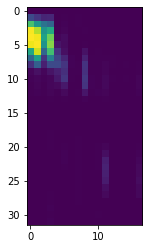

In [59]:
#plt.imshow(x_val[0])
#plt.imshow(y_val[0,:,:,2])
print(y_val.shape)
print(preds2.shape)
pl = preds[0,:,:,:]
print(pl.shape)
plt.imshow(pl[1,:,:])

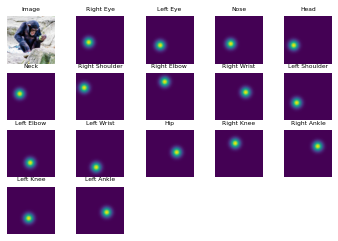

In [93]:
view_my_maps(np.moveaxis(x_val[6,:,:,:],0,2),y_val2[6,:,:,:])

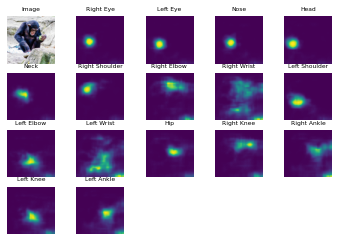

In [94]:
view_my_maps(np.moveaxis(x_val[6,:,:,:],0,2),preds2[6,:,:,:])